# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [3]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - number of gameweeks required
FFP = 15

NEXT_GAMEWEEK = 19

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [ ]:
# device = torch.device("cuda")
# device = torch.device('mps')
device = torch.device('cpu')

# Getting data and choosing features

In [5]:
df = pd.read_csv('data/final_dataset.csv')

In [6]:
# remembering original df
df_original = df

In [7]:
# df.iloc[1]

In [8]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [9]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

C:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
df.shape

(7457, 13)

In [11]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking onyl players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [12]:
df.shape

(5771, 13)

In [13]:
df.head(20)

,Name,GW,FPL position,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Brenden-Aaronson,1,MID,83.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,Brenden-Aaronson,2,MID,90.0,0.0,2.0,0.0,0.1,0.1,0.1,0.0,0.0,2.0
2,Brenden-Aaronson,3,MID,82.0,1.0,2.0,2.0,1.0,1.0,0.1,1.0,1.0,8.0
3,Brenden-Aaronson,4,MID,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,Brenden-Aaronson,5,MID,75.0,0.0,1.0,1.0,0.1,0.1,0.1,0.0,1.0,5.0
5,Brenden-Aaronson,6,MID,90.0,0.0,1.0,0.0,0.0,0.0,0.3,0.0,0.0,2.0
6,Brenden-Aaronson,9,MID,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0
7,Brenden-Aaronson,10,MID,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0
8,Brenden-Aaronson,11,MID,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0
9,Brenden-Aaronson,12,MID,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0


In [14]:
last_names = df["Name"].unique()

In [15]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Sh', 'SoT', 'xG', 'npxG',
       'xAG', 'CS', 'Was Home', 'FPL'],
      dtype='object')

In [16]:
df["FPL position"].unique()

array(['MID', 'FWD', 'DEF', 'GK'], dtype=object)

# DF to DataLoader

In [17]:
# gk, def, mid, fwd
df_gk = df[df["FPL position"] == "GK"]
df_def = df[df["FPL position"] == "DEF"]
df_mid = df[df["FPL position"] == "MID"]
df_fwd = df[df["FPL position"] == "FWD"]

In [18]:
df.shape

(5771, 13)

In [19]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [20]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.index_table = init_index_table(dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        length = 0
        for name in self.names:
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [21]:
# df[["Name", "FPL position"]].drop_duplicates().head(20)

In [22]:
dataset = PandasDataset(df)
dataset_gk = PandasDataset(df_gk)
dataset_def = PandasDataset(df_def)
dataset_mid = PandasDataset(df_mid)
dataset_fwd = PandasDataset(df_fwd)

In [23]:
dataset.__getitem__(0)

(array([[83. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.1,  0. ,  0. ],
        [82. ,  1. ,  2. ,  2. ,  1. ,  1. ,  0.1,  1. ,  1. ],
        [81. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [75. ,  0. ,  1. ,  1. ,  0.1,  0.1,  0.1,  0. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0.3,  0. ,  0. ],
        [78. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  1. ,  1. ],
        [75. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ]],
       dtype=float32),
 2.0)

In [24]:
dataset_fwd.__getitem__(10)

(array([[90. ,  1. ,  2. ,  1. ,  0.4,  0.4,  0. ,  1. ,  0. ],
        [18. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  5. ,  2. ,  0.7,  0.7,  0.1,  0. ,  0. ],
        [63. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.1,  0. ,  1. ],
        [90. ,  1. ,  3. ,  2. ,  0.6,  0.6,  0.2,  0. ,  0. ],
        [90. ,  0. ,  1. ,  0. ,  0.2,  0.2,  0.1,  0. ,  1. ],
        [90. ,  0. ,  3. ,  1. ,  0.4,  0.4,  0.1,  0. ,  0. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0. ,  0. ,  1. ]],
       dtype=float32),
 5.0)

In [25]:
dataset_gk.__len__()

305

In [26]:
dataset_def.__len__()

1137

In [27]:
dataset_mid.__len__()

1469

In [28]:
dataset_fwd.__len__()

356

In [29]:
batch_size = 16

In [30]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_gk = DataLoader(dataset_gk, batch_size=batch_size, shuffle=False)
dataloader_def = DataLoader(dataset_def, batch_size=batch_size, shuffle=False)
dataloader_mid = DataLoader(dataset_mid, batch_size=batch_size, shuffle=False)
dataloader_fwd = DataLoader(dataset_fwd, batch_size=batch_size, shuffle=False)

In [31]:
# next(iter(dataloader_mid))

In [32]:
# next(iter(dataloader))[1]

# LSTM Model

In [33]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [34]:
len(dataloader)

205

In [35]:
# torch.transpose(next(iter(dataloader))[0], 0, 1).shape

In [36]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [37]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [38]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [39]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [40]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

# Training loops

In [41]:
criterion = nn.MSELoss()

In [42]:
def train_net(net, num_epochs, dataloader, optimizer):
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten()
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [43]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Training loop - general net

In [44]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 30, dataloader, optimizer)

Epoch 0 Loss: 3.90499411167168
Epoch 5 Loss: 3.676606894048249
Epoch 10 Loss: 3.6752017870181946
Epoch 15 Loss: 3.675561840287069
Epoch 20 Loss: 3.4248463400253435
Epoch 25 Loss: 3.113339597132148
CPU times: total: 29min 57s
Wall time: 9min 27s


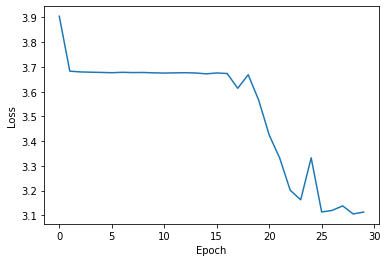

In [45]:
plot_loss_history(loss_history)

## Training loop - goalkeeper net

In [46]:
%%time
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 50, dataloader_gk, optimizer_gk)

Epoch 0 Loss: 1.8552665770053864
Epoch 5 Loss: 0.5015691663138568
Epoch 10 Loss: 0.4959846164099872
Epoch 15 Loss: 0.4965502420905977
Epoch 20 Loss: 0.5014620403759181
Epoch 25 Loss: 0.4974045859416947
Epoch 30 Loss: 0.4980439692735672
Epoch 35 Loss: 0.4981412414461374
Epoch 40 Loss: 0.49796056407503786
Epoch 45 Loss: 0.498907684488222
CPU times: total: 4min 6s
Wall time: 1min 21s


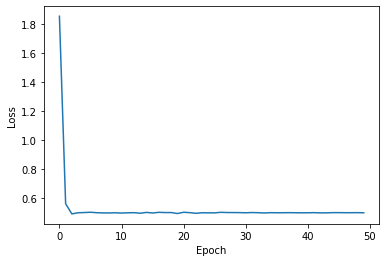

In [47]:
plot_loss_history(loss_history_gk)

## Training loop - defender net

In [48]:
%%time
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 50, dataloader_def, optimizer_def)

Epoch 0 Loss: 1.7999306221803029
Epoch 5 Loss: 1.2677056588646438
Epoch 10 Loss: 1.2558547906163666
Epoch 15 Loss: 1.2523571252822876
Epoch 20 Loss: 1.2511383949054613
Epoch 25 Loss: 1.2507698867056105
Epoch 30 Loss: 1.252049196511507
Epoch 35 Loss: 1.2503230043997366
Epoch 40 Loss: 1.250391547050741
Epoch 45 Loss: 1.2507200830926497
CPU times: total: 16min 7s
Wall time: 5min 17s


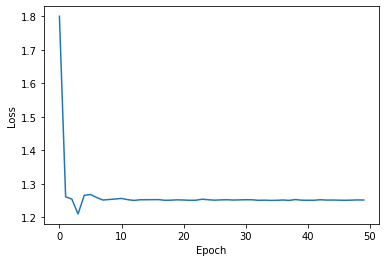

In [49]:
plot_loss_history(loss_history_def)

## Training loop - midfielder net

In [50]:
%%time
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 50, dataloader_mid, optimizer_mid)

Epoch 0 Loss: 5.234412087694459
Epoch 5 Loss: 4.641979807096979
Epoch 10 Loss: 4.296503126297308
Epoch 15 Loss: 4.056585997343063
Epoch 20 Loss: 4.032497091461783
Epoch 25 Loss: 3.98745010048151
Epoch 30 Loss: 3.955443128295567
Epoch 35 Loss: 3.963741829213889
Epoch 40 Loss: 3.930608530731305
Epoch 45 Loss: 3.910403011933617
CPU times: total: 20min 47s
Wall time: 6min 47s


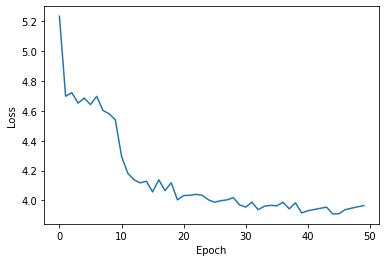

In [51]:
plot_loss_history(loss_history_mid)

## Training loop - forward net

In [52]:
%%time
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.005)
loss_history_fwd = train_net(net_fwd, 50, dataloader_fwd, optimizer_fwd)

Epoch 0 Loss: 12.668241068072941
Epoch 5 Loss: 8.356820541879404
Epoch 10 Loss: 8.353546025960341
Epoch 15 Loss: 8.29906195661296
Epoch 20 Loss: 7.822572881760805
Epoch 25 Loss: 7.5175846996514695
Epoch 30 Loss: 7.5767896019894145
Epoch 35 Loss: 6.886623357301173
Epoch 40 Loss: 6.71058558769848
Epoch 45 Loss: 7.170006130052649
CPU times: total: 4min 26s
Wall time: 1min 15s


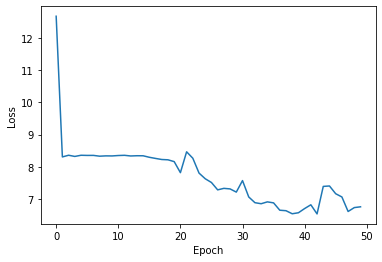

In [53]:
plot_loss_history(loss_history_fwd)

# Predictions - general model

In [54]:
index = 0
predictions = []
index_table = init_index_table(df) # index table for whole dataframe

for inputs, target in dataloader:
    inputs = torch.flatten(inputs, 1, 2)
    inputs = inputs.unsqueeze(2)
    # print("INPUTS", inputs)
    # print(inputs)
    outputs = net(inputs)
    # print("OUTPUTS", outputs)
    for output in outputs:
        player_id, sample_id = index_table[index]
        name = last_names[player_id]
        points = round(output.item(), 2)
        gw = sample_id + FIS + 1
        predictions.append([name, gw, points])
        # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
        index += 1

In [55]:
# appending results to original df
for name, gw, points in predictions:
    df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [56]:
df_original

,Unnamed: 0,Date,Day,Comp,Round,Venue,Squad,Opponent,Start,Pos,...,Was Home,GW,FPL,neutral_name,Total Points,FPL position,Opp rating,ScoreForLast5,ScoreAgainstLast5,LSTM
0,0,2022-08-06,Sat,Premier League,Matchweek 1,Home,Leeds United,Wolves,Y,RW,...,1.0,1,2.0,Brenden-Aaronson,2.0,MID,1725.276489,NaN,NaN,NaN
1,1,2022-08-13,Sat,Premier League,Matchweek 2,Away,Leeds United,Southampton,Y,"RW,AM",...,0.0,2,2.0,Brenden-Aaronson,1.0,MID,1667.049927,2.000000,1.0,NaN
2,2,2022-08-21,Sun,Premier League,Matchweek 3,Home,Leeds United,Chelsea,Y,AM,...,1.0,3,8.0,Brenden-Aaronson,8.0,MID,1901.388306,2.000000,1.5,NaN
3,3,2022-08-27,Sat,Premier League,Matchweek 4,Away,Leeds United,Brighton,Y,"AM,RW",...,0.0,4,2.0,Brenden-Aaronson,1.0,MID,1783.540161,2.333333,1.0,NaN
4,4,2022-08-30,Tue,Premier League,Matchweek 5,Home,Leeds United,Everton,Y,"AM,RW",...,1.0,5,5.0,Brenden-Aaronson,5.0,MID,1688.922485,1.750000,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7452,7452,2022-12-26,Mon,Premier League,Matchweek 17,Home,Arsenal,West Ham,Y*,RM,...,1.0,17,8.0,Martin-Odegaard,11.0,MID,1768.070923,2.000000,0.2,4.44
7453,7453,2022-12-31,Sat,Premier League,Matchweek 18,Away,Arsenal,Brighton,Y*,RM,...,0.0,18,10.0,Martin-Odegaard,13.0,MID,1799.850708,2.400000,0.4,4.34
7454,7454,2023-01-03,Tue,Premier League,Matchweek 19,Home,Arsenal,Newcastle Utd,Y*,RM,...,1.0,19,3.0,Martin-Odegaard,2.0,MID,1850.296631,3.000000,0.6,NaN
7455,7455,2023-01-15,Sun,Premier League,Matchweek 20,Away,Arsenal,Tottenham,Y*,RM,...,0.0,20,8.0,Martin-Odegaard,9.0,MID,1868.577759,2.000000,0.6,NaN


In [57]:
df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

In [58]:
# results sorted
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
1290,Erling-Haaland,11,4.99
1292,Erling-Haaland,13,4.93
1548,Harry-Kane,11,4.64
2564,Mohamed-Salah,11,4.52
1390,Son-Heung-min,18,4.51
2917,Ivan-Toney,16,4.51
2404,Marcus-Rashford,18,4.50
1295,Erling-Haaland,16,4.49
2552,Bukayo-Saka,10,4.48
1550,Harry-Kane,13,4.48


# Predictions for each position

In [59]:
def predictions_for_position(dataloader_pos, dataset_pos, net_pos):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            gw = sample_id + FIS + 1
            predictions_pos.append([name, gw, points])
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    return predictions_pos

## Goalkeepers

In [60]:
predictions_gk = predictions_for_position(dataloader_gk, dataset_gk, net_gk)

In [61]:
# results sorted
pd.DataFrame(predictions_gk, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
236,David-Raya,12,2.13
126,Dean-Henderson,18,2.13
250,Marek-Rodak,14,2.13
128,Wayne-Hennessey,10,2.13
67,Ederson,20,2.13
195,Robin-Olsen,17,2.13
131,Wayne-Hennessey,13,2.13
63,Ederson,16,2.13
192,Robin-Olsen,14,2.13
59,Ederson,12,2.13


## Defenders

In [62]:
predictions_def = predictions_for_position(dataloader_def, dataset_def, net_def)

In [63]:
# results sorted
pd.DataFrame(predictions_def, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
0,Tosin-Adarabioyo,9,2.24
625,Scott-McKenna,9,2.24
608,Tyrell-Malacia,14,2.24
610,Tyrell-Malacia,16,2.24
614,Tyrell-Malacia,20,2.24
615,Lisandro-Martinez,9,2.24
616,Lisandro-Martinez,10,2.24
618,Lisandro-Martinez,12,2.24
621,Lisandro-Martinez,15,2.24
622,Lisandro-Martinez,16,2.24


## Midfielders

In [64]:
predictions_mid = predictions_for_position(dataloader_mid, dataset_mid, net_mid)

In [65]:
# results sorted
pd.DataFrame(predictions_mid, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
1265,Mohamed-Salah,13,5.08
109,Harvey-Barnes,10,5.07
1251,Bukayo-Saka,10,5.05
112,Harvey-Barnes,13,5.04
1252,Bukayo-Saka,11,4.94
678,Son-Heung-min,18,4.93
1266,Mohamed-Salah,14,4.93
1366,Leandro-Trossard,13,4.91
308,Kevin-De-Bruyne,18,4.89
113,Harvey-Barnes,14,4.88


## Forwards

In [66]:
predictions_fwd = predictions_for_position(dataloader_fwd, dataset_fwd, net_fwd)

In [67]:
# results sorted
pd.DataFrame(predictions_fwd, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
112,Erling-Haaland,15,5.89
111,Erling-Haaland,14,5.88
282,Ivan-Toney,11,5.88
116,Erling-Haaland,19,5.88
167,Harry-Kane,11,5.88
106,Erling-Haaland,9,5.87
329,Ollie-Watkins,19,5.87
128,Kai-Havertz,20,5.87
339,Callum-Wilson,11,5.87
171,Harry-Kane,15,5.87
